In [1]:
# !pip install transformers
# !pip install tensorflow_datasets
# !pip install torchvision
# import tensorflow as tf; 
# print(tf.__version__)


In [2]:
import pandas as pd
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud
from textblob import Word


import tensorflow as tf
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
from tensorflow import keras

import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression


from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import random
import array
import warnings
warnings.filterwarnings('ignore')



Num GPUs Available:  0


#### Download Review

In [3]:
reviews = pd.read_csv('data/review_guitar.csv',index_col=[0])
reviews

,stars,body,date
0,1.0,This type of Guitar has following disadvantage...,31 May 2018
1,5.0,As a layman (who doesn't know much about guita...,14 October 2018
2,5.0,For 2000 rs its a really really good purchase....,11 August 2018
3,1.0,pros:* The guitar has fair sound for its price...,30 January 2019
4,5.0,The media could not be loaded.\n ...,26 January 2022
...,...,...,...
4995,4.0,This product was good but i received a broken ...,17 May 2017
4996,5.0,Its perfectly safe if you are a beginner like ...,1 February 2016
4997,5.0,Good one,5 June 2020
4998,5.0,Mast h,25 November 2019


### EDA

In [4]:
reviews.describe()

,stars
count,5000.000000
mean,3.734600
std,1.458283
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [5]:
reviews["body"]

0       This type of Guitar has following disadvantage...
1       As a layman (who doesn't know much about guita...
2       For 2000 rs its a really really good purchase....
3       pros:* The guitar has fair sound for its price...
4       The media could not be loaded.\n              ...
                              ...                        
4995    This product was good but i received a broken ...
4996    Its perfectly safe if you are a beginner like ...
4997                                             Good one
4998                                               Mast h
4999    It sounds grt i love this guiter best product ...
Name: body, Length: 5000, dtype: object

In [6]:
reviews.dtypes

stars    float64
body      object
date      object
dtype: object

In [7]:
reviews.shape

(5000, 3)

<AxesSubplot:xlabel='stars', ylabel='Density'>

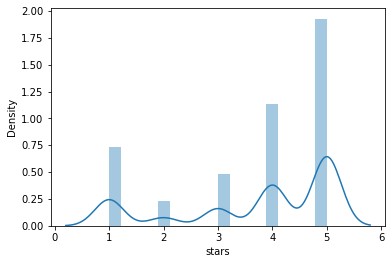

In [8]:
import seaborn as sn
sn.distplot(reviews['stars'])

<AxesSubplot:ylabel='stars'>

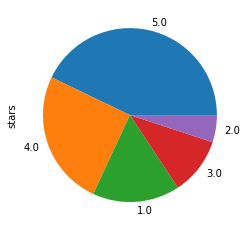

In [9]:
reviews['stars'].value_counts().plot(kind="pie")

(array([ 811.,    0.,  252.,    0.,    0.,  533.,    0., 1261.,    0.,
        2143.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

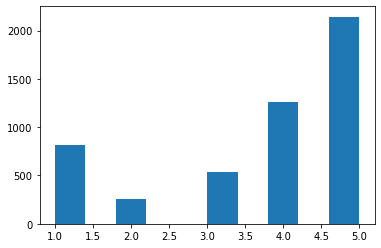

In [10]:
plt.hist(reviews['stars'])

In [11]:
reviews.isna().sum()

stars     0
body     28
date      0
dtype: int64

In [12]:
reviews.dropna(inplace=True)

In [13]:
reviews.isna().sum()

stars    0
body     0
date     0
dtype: int64

In [14]:
reviews.isnull().sum()

stars    0
body     0
date     0
dtype: int64

### Text preprocessing

In [15]:
reviews.drop(['date'], axis = 1,inplace=True)

In [16]:
def remove_tags(string):
    removelist = ""
    result = re.sub(r'^RT[\s]+', '', string)
    # remove hyperlinks
    result = re.sub(r'https?:\/\/.*[\r\n]*', '', result)
    result = re.sub(r'#', '', result)
    # removing hyphens
    result = re.sub('-', ' ', result)
    # remove linebreaks
    result = re.sub('<br\s?\/>|<br>', "", result)
    # remving numbers
    result = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b",'',result)

    result = re.sub('','',result)          #remove HTML tags
    result = re.sub('https://.*','',result)   #remove URLs
    result = result.lower()
    return result
reviews['short_review']=reviews['body'].apply(lambda cw : remove_tags(cw))

In [17]:
stop_words = set(stopwords.words('english'))
reviews['short_review'] = reviews['short_review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [18]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
reviews['short_review'] = reviews.short_review.apply(lemmatize_text)

In [19]:
reviews

,stars,body,short_review
0,1.0,This type of Guitar has following disadvantage...,type guitar following disadvantages1.the strin...
1,5.0,As a layman (who doesn't know much about guita...,layman (who know much guitars) product awesome...
2,5.0,For 2000 rs its a really really good purchase....,r really really good purchase...i beginner bou...
3,1.0,pros:* The guitar has fair sound for its price...,pros:* guitar fair sound price.* look goodcon:...
4,5.0,The media could not be loaded.\n ...,medium could loaded. loved
...,...,...,...
4995,4.0,This product was good but i received a broken ...,product good received broken one.
4996,5.0,Its perfectly safe if you are a beginner like ...,perfectly safe beginner like me.. want go comp...
4997,5.0,Good one,good one
4998,5.0,Mast h,mast h


In [20]:
reviews["Sentiment"] = reviews["stars"].apply(lambda score: "positive" if score >= 3 else "negative")
reviews['Sentiment'] = reviews['Sentiment'].map({'positive':1, 'negative':0})
reviews_df = reviews[["short_review", "Sentiment"]]
reviews_df.dropna(inplace=True)
temp_reviews = reviews_df.copy()
reviews_df

,short_review,Sentiment
0,type guitar following disadvantages1.the strin...,0
1,layman (who know much guitars) product awesome...,1
2,r really really good purchase...i beginner bou...,1
3,pros:* guitar fair sound price.* look goodcon:...,0
4,medium could loaded. loved,1
...,...,...
4995,product good received broken one.,1
4996,perfectly safe beginner like me.. want go comp...,1
4997,good one,1
4998,mast h,1


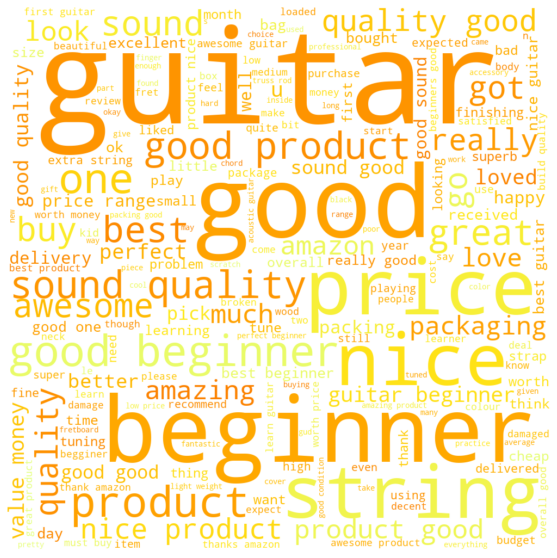

In [21]:
# Polarity == 1 positive
train_s2 = reviews_df[reviews_df.Sentiment ==1]
all_text = ' '.join(word for word in train_s2.short_review)
wordcloud_p2 = WordCloud(width=1000, height=1000, colormap='Wistia',background_color='white', mode='RGBA').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_p2, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

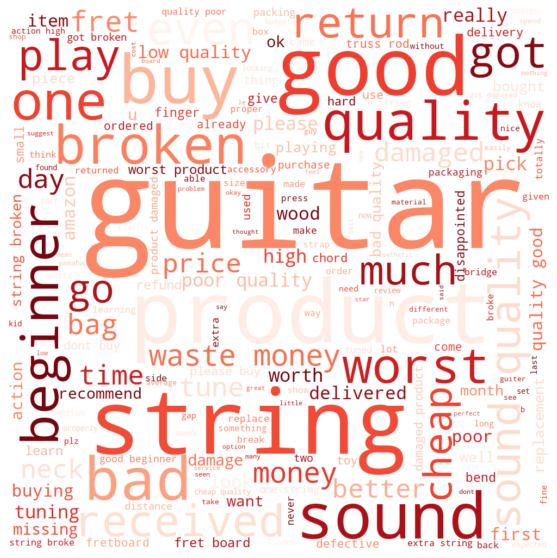

In [22]:
# Polarity == 0 negative
train_s0 = reviews_df[reviews_df.Sentiment ==0]
all_text = " ".join(word for word in train_s0.short_review)
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

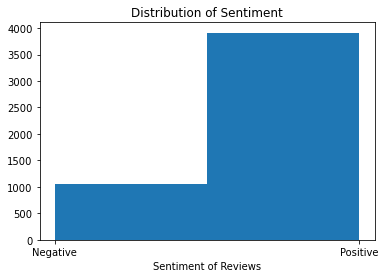

In [23]:
import matplotlib.pyplot as plt
plt.hist(reviews_df.Sentiment, bins = 2, align= 'mid')
plt.xticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Sentiment of Reviews')
plt.title('Distribution of Sentiment')
plt.show()

###  Split Data into Train & Test

In [24]:
short_reviews = reviews_df['short_review'].values
labels = reviews_df['Sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [25]:
from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(short_reviews, encoded_labels, stratify = encoded_labels)
print(train_sentences.shape)
print(test_sentences.shape)
print(train_labels.shape)
print(test_labels.shape)

print(reviews_df.shape)
# sanity check 
reviews_df.shape[0] == (train_sentences.shape[0] + test_sentences.shape[0])


(3729,)
(1243,)
(3729,)
(1243,)
(4972, 2)


True

### Loading Tokenizer and Encoding our Data

In [26]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

## Model Building - LSTM

In [27]:
LSTM_model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
LSTM_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [28]:
num_epochs = 5
history = LSTM_model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
105/105 [==============================] - 13s 96ms/step - loss: 0.4341 - accuracy: 0.8167 - val_loss: 0.3185 - val_accuracy: 0.8767
Epoch 2/5
105/105 [==============================] - 8s 75ms/step - loss: 0.2589 - accuracy: 0.8960 - val_loss: 0.2997 - val_accuracy: 0.8767
Epoch 3/5
105/105 [==============================] - 8s 81ms/step - loss: 0.1952 - accuracy: 0.9309 - val_loss: 0.3517 - val_accuracy: 0.8740
Epoch 4/5
105/105 [==============================] - 8s 78ms/step - loss: 0.1529 - accuracy: 0.9470 - val_loss: 0.3927 - val_accuracy: 0.8660
Epoch 5/5
105/105 [==============================] - 8s 79ms/step - loss: 0.1285 - accuracy: 0.9580 - val_loss: 0.4577 - val_accuracy: 0.8686


### Model Evaluvation

In [29]:
scores = LSTM_model.evaluate(test_padded, test_labels,verbose=0)
LSTM_accuracy = scores[1]*100
print('Test accuracy: ', scores[1]*100, '%')

Test accuracy:  86.08205914497375 %


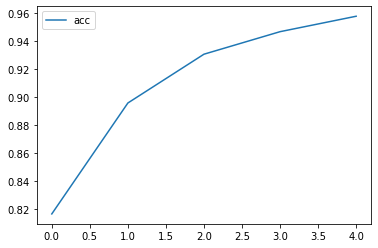

In [30]:
plt.plot(history.history['accuracy'], label='acc')
plt.legend()
plt.show()

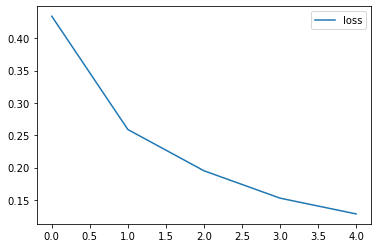

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

### Model Prediction

In [32]:
prediction = LSTM_model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

39/39 [==============================] - 2s 30ms/step
Accuracy of prediction on test set :  0.8608205953338697


### Determine the sentiment of product reviews

In [33]:
# reviews on which we need to predict
sentence = ["Everything was fine but the tuning strings was not able to tune either going on high frequency or low frequencyWhile playing chords the chords was disturbing other strings due to low quality fret work", 
            "Worst product ever.dont buy this product.0 star and more over I didn't got refund money", 
            "Received my guitar today.. and I totally loved it....Didn't knew I'll receive such a good product...As a beginner, I can't wait to play it.."]
random.shuffle(sentence)
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = LSTM_model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s,"\n")

1/1 [==============================] - 0s 35ms/step
Received my guitar today.. and I totally loved it....Didn't knew I'll receive such a good product...As a beginner, I can't wait to play it..
Predicted sentiment :  Positive 

Everything was fine but the tuning strings was not able to tune either going on high frequency or low frequencyWhile playing chords the chords was disturbing other strings due to low quality fret work
Predicted sentiment :  Negative 

Worst product ever.dont buy this product.0 star and more over I didn't got refund money
Predicted sentiment :  Negative 



## Using Naive Bayes

### Split Train and Test

In [34]:
# Split into training and testing data
x = reviews_df['short_review']
y = reviews_df['Sentiment']
x, x_test, y, y_test = train_test_split(x,y, stratify=y, test_size=0.20, random_state=42)

### Vectorize text reviews to numbers.

In [35]:
vec = CountVectorizer(stop_words='english')
x = vec.fit_transform(x).toarray()
x_test = vec.transform(x_test).toarray()

### Model Building

In [36]:
from sklearn.naive_bayes import MultinomialNB

NAIVE_BASE_model = MultinomialNB()
NAIVE_BASE_model.fit(x, y)

MultinomialNB()

In [37]:
NAIVE_BASE_accuracy = NAIVE_BASE_model.score(x_test, y_test)*100
NAIVE_BASE_accuracy

86.83417085427135

In [38]:
NAIVE_BASE_model.predict(vec.transform(['Love this app simply awesome!']))

array([1], dtype=int64)

In [39]:
# reviews on which we need to predict
sentence = ["Everything was fine but the tuning strings was not able to tune either going on high frequency or low frequencyWhile playing chords the chords was disturbing other strings due to low quality fret work", 
            "Worst product ever.dont buy this product.0 star and more over I didn't got refund money", 
            "Received my guitar today.. and I totally loved it....Didn't knew I'll receive such a good product...As a beginner, I can't wait to play it.."]
random.shuffle(sentence)
# convert to a number
naive_transform = vec.transform(sentence)
prediction = NAIVE_BASE_model.predict(naive_transform)
pred_labels = []
for i in prediction:
    if i ==1 :
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s,"\n")

Everything was fine but the tuning strings was not able to tune either going on high frequency or low frequencyWhile playing chords the chords was disturbing other strings due to low quality fret work
Predicted sentiment :  Negative 

Received my guitar today.. and I totally loved it....Didn't knew I'll receive such a good product...As a beginner, I can't wait to play it..
Predicted sentiment :  Positive 

Worst product ever.dont buy this product.0 star and more over I didn't got refund money
Predicted sentiment :  Negative 



## Using Logistic Regression

###  Vectorize text reviews to numbers.


In [40]:
vectorizer = CountVectorizer(max_features=300, stop_words='english')
X = vectorizer.fit_transform(reviews_df['short_review']).toarray()

### Split dataset

In [41]:
from sklearn.model_selection import train_test_split

y = reviews_df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Model Building

In [42]:
Logistic_Regression_model = LogisticRegression( max_iter=5000,  dual=False)
Logistic_Regression_model.fit(X_train, y_train,)

LogisticRegression(max_iter=5000)

### Model Evaluvation

In [55]:
logistic_accuracy = cross_val_score(Logistic_Regression_model, X_test, y_test, cv=5, scoring='accuracy')
logistic_accuracy.mean()*100

85.52763819095478

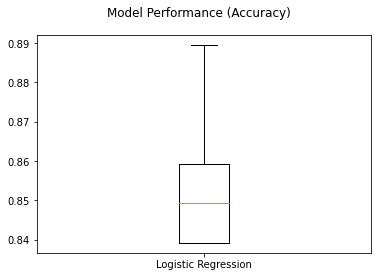

In [47]:
fig = plt.figure()
fig.suptitle('Model Performance (Accuracy)')
ax = fig.add_subplot(111)
ax.set_xticklabels(['Logistic Regression'])
plt.boxplot(logistic_accuracy)
plt.show()

### Model Prediction

In [45]:
# reviews on which we need to predict
sentence = ["Everything was fine but the tuning strings was not able to tune either going on high frequency or low frequencyWhile playing chords the chords was disturbing other strings due to low quality fret work", 
            "Worst product ever.dont buy this product.0 star and more over I didn't got refund money", 
            "Received my guitar today.. and I totally loved it....Didn't knew I'll receive such a good product...As a beginner, I can't wait to play it.."]
random.shuffle(sentence)
# convert to a number
transform = vectorizer.transform(sentence)
prediction = Logistic_Regression_model.predict(transform)
pred_labels = []
for i in prediction:
    if i ==1 :
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s,"\n")

Everything was fine but the tuning strings was not able to tune either going on high frequency or low frequencyWhile playing chords the chords was disturbing other strings due to low quality fret work
Predicted sentiment :  Negative 

Worst product ever.dont buy this product.0 star and more over I didn't got refund money
Predicted sentiment :  Negative 

Received my guitar today.. and I totally loved it....Didn't knew I'll receive such a good product...As a beginner, I can't wait to play it..
Predicted sentiment :  Positive 



In [56]:
data = [[LSTM_accuracy], [NAIVE_BASE_accuracy], [logistic_accuracy.mean()*100]]
df = pd.DataFrame(data, columns=['Accuracy'],index=['LSTM',
                               'NAIVE BASE',
                               'Logistic_Regression'])
df

,Accuracy
LSTM,86.082059
NAIVE BASE,86.834171
Logistic_Regression,85.527638


### # We choose NAIVE BASE as best model for sentiment Analysis of Amazone Product

### Create Pickle File

In [60]:
# loading library
# import pickle
# filename = 'finalized_model.pkl' 
# f = open(filename,'wb')
# pickle.dump(NAIVE_BASE_model,f)
# f.close()